<a href="https://colab.research.google.com/github/Utkarsh87/Capsule-Networks/blob/master/CapsNet%20MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [0]:
import numpy as np
import tensorflow as tf

In [0]:
tf.compat.v1.reset_default_graph()

In [0]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


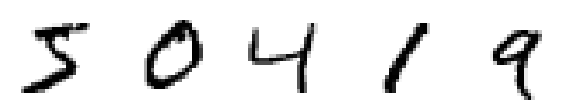

In [0]:
n_samples = 5

plt.figure(figsize=(n_samples * 2, 3))
for index in range(n_samples):
    plt.subplot(1, n_samples, index + 1)
    sample_image = train_images[index].reshape(28, 28)
    plt.imshow(sample_image, cmap="binary")
    plt.axis("off")

plt.show()

In [0]:
relu_conv1 = tf.keras.layers.Conv2D(256, (9, 9), strides=(1, 1), input_shape=(None, 28, 28, 1))
conv2 = tf.keras.layers.Conv2D(256, (9, 9), strides=(2, 2), input_shape=(None, 20, 20, 256))

In [0]:
# print(type(train_images[0]))
train_images = train_images.reshape((train_images.shape[0], 28, 28, 1))
train_images = train_images*1.0/255.0
# print(train_images.shape)
batch_size = 64
samples_per_batch = train_images.shape[0]//batch_size
for i in range(samples_per_batch):
  x = (relu_conv1(train_images[i*batch_size : (i+1)*batch_size]))
  print(x.shape)
  op = (conv2(x))
  # print(op.shape)
# op1 = relu_conv1(train_images))

(64, 20, 20, 256)


ValueError: ignored